In [1]:
DF_PATH = 'C:/Users/Access/ITI/data_science_skills/data/processed/1_preprocessed_df.pkl'
ROLES_PATH = 'C:/Users/Access/ITI/data_science_skills/data/raw/roles_short_names.csv'

NA_STRING = 'Not Specified'
TRANSPARENT_STRING = 'rgba(0, 0, 0, 0)'

ROLE_COLS = ['DevType']
TECH_COLS = ['LanguageWorkedWith' , 'DatabaseWorkedWith' , 'WebframeWorkedWith', 'MiscTechWorkedWith']
TECH_NEXT_COLS = ['LanguageDesireNextYear', 'DatabaseDesireNextYear' , 'WebframeDesireNextYear' , 'MiscTechDesireNextYear']

In [2]:
## Major Libraries
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

## Other
import os, joblib, missingno
import logging
import pickle

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

## sklearn -- Preprocessing & Tuning & Transformation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures , MultiLabelBinarizer , RobustScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion , make_pipeline
from sklearn_features.transformers import DataFrameSelector

## sklearn -- metrics
from sklearn.metrics import mean_squared_error, r2_score

## sklearn -- Models
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.cluster import KMeans , AgglomerativeClustering

## Xgboost
from xgboost import XGBRegressor

Read data and preprocess

In [3]:
# Read Data
raw_df = pd.read_pickle(DF_PATH)
# roles_names = pd.read_csv(ROLES_PATH , sep=';')

------------------------------------------------------------------------------------------------------------------------------------------------

Onehot encode

In [4]:
df = raw_df.copy()
encoded_dfs = {}
for col in ROLE_COLS + TECH_COLS :
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(df[col]),
                            columns = binarizer.classes_,
                            index=df[col].index)
    encoded_dfs[col] = encoded_df

In [5]:
# merge 1-hot encoded
df = pd.concat(encoded_dfs, axis=1)

In [6]:
df.head()

DevType                           \
  Academic researcher Data or business analyst   
0                   0                        0   
1                   0                        0   
2                   0                        0   
3                   0                        0   
4                   0                        0   

                                                                        \
  Data scientist or machine learning specialist Database administrator   
0                                             0                      0   
1                                             0                      0   
2                                             0                      0   
3                                             0                      0   
4                                             0                      0   

                                                                        \
  Designer DevOps specialist Developer, QA or test Developer, back-end   
0        0                 0                     0                   0   
1        0                 0                     0                   0   
2        0                 0                     0                   0   
3        0                 0                     0                   0   
4        0                 0                     0                   0   

                                                 \
  Developer, desktop or enterprise applications   
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

                                               ... MiscTechWorkedWith         \
  Developer, embedded applications or devices  ...            Node.js Pandas   
0                                           0  ...                  0      0   
1                                           0  ...                  0      0   
2                                           0  ...                  0      0   
3                                           0  ...                  0      0   
4                                           0  ...                  0      0   

                                                                  \
  Puppet React Native TensorFlow Teraform Torch/PyTorch Unity 3D   
0      0            0          0        0             0        0   
1      0            1          0        0             0        0   
2      0            0          0        0             0        0   
3      0            0          0        0             0        0   
4      0            0          0        0             0        0   

                         
  Unreal Engine Xamarin  
0             0       0  
1             0       0  
2             0       0  
3             0       0  
4             0       0  

[5 rows x 97 columns]

In [7]:
raw_df['DevType'][1]

['Developer, full-stack', 'Developer, mobile']

In [24]:
df.columns[1]

('DevType', 'Data or business analyst')

In [9]:
df.drop('DevType' , axis = 1).sum()

LanguageWorkedWith  Assembly                  3553
                    Bash/Shell/PowerShell    18980
                    C                        12487
                    C#                       18041
                    C++                      13707
                                             ...  
MiscTechWorkedWith  Teraform                  2518
                    Torch/PyTorch             1872
                    Unity 3D                  4413
                    Unreal Engine             1316
                    Xamarin                   2357
Length: 74, dtype: int64

--------------------------------------------------------------------------------------------------------------------------------------

Display Skills Frequency

In [10]:
# calculate the sum for all cols except DevTypes
skills_freq = df.drop('DevType' , axis = 1).sum().reset_index()
skills_freq.head()

,level_0,level_1,0
0,LanguageWorkedWith,Assembly,3553
1,LanguageWorkedWith,Bash/Shell/PowerShell,18980
2,LanguageWorkedWith,C,12487
3,LanguageWorkedWith,C#,18041
4,LanguageWorkedWith,C++,13707


In [11]:
skills_freq.columns = ['group' , 'skill' , 'freq']

In [12]:
skills_freq

,group,skill,freq
0,LanguageWorkedWith,Assembly,3553
1,LanguageWorkedWith,Bash/Shell/PowerShell,18980
2,LanguageWorkedWith,C,12487
3,LanguageWorkedWith,C#,18041
4,LanguageWorkedWith,C++,13707
...,...,...,...
69,MiscTechWorkedWith,Teraform,2518
70,MiscTechWorkedWith,Torch/PyTorch,1872
71,MiscTechWorkedWith,Unity 3D,4413
72,MiscTechWorkedWith,Unreal Engine,1316


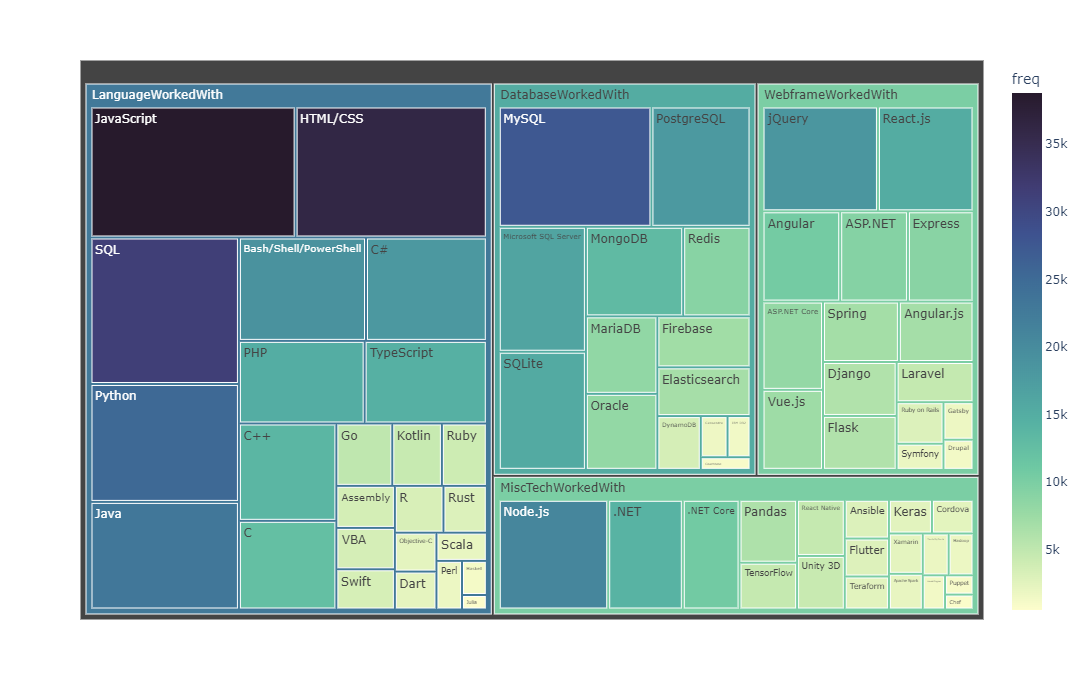

In [17]:
fig = px.treemap(skills_freq,
                 path=['group','skill'],
                 color_continuous_scale='deep',
                 values='freq',color='freq')

fig.update_layout(width=1000,height=700)

fig.show()

---------------------------------------------------------------------------------------------------------------

Create jobs and skills heatmap

In [18]:
sorted_roles = df['DevType'].sum().sort_values().index.tolist()
sorted_skills = df.drop('DevType',axis=1).sum().sort_values(ascending=False).droplevel(level=0).index.tolist()

In [28]:
skills = []
for role in sorted_roles:
    role_mask = (df[('DevType', role)] == 1)
    skills_role = pd.concat({tech_col: df.loc[role_mask , tech_col].mean() * 100
                            for tech_col in TECH_COLS})
    skills.append(skills_role)

skills = pd.concat(skills , axis=1)


skills.columns = sorted_roles
skills = skills.reset_index(level=0,drop=True)
skills = skills.loc[sorted_skills]

skills = skills.T
skills

,JavaScript,HTML/CSS,SQL,MySQL,Python,Java,Node.js,Bash/Shell/PowerShell,jQuery,C#,...,Gatsby,Cassandra,IBM DB2,Drupal,Unreal Engine,Haskell,Puppet,Couchbase,Chef,Julia
Marketing or sales professional,71.028037,76.635514,57.788162,61.370717,38.629283,32.242991,41.744548,31.152648,45.482866,25.700935,...,9.034268,5.919003,5.763240,9.968847,6.853583,4.205607,4.517134,6.230530,4.672897,4.049844
Senior executive/VP,72.878788,69.166667,65.075758,49.545455,45.984848,33.333333,43.787879,44.393939,36.439394,34.848485,...,5.227273,6.590909,5.227273,6.060606,4.318182,3.409091,4.848485,5.227273,3.939394,2.727273
"Engineer, site reliability",65.876289,58.505155,61.701031,53.762887,59.896907,39.948454,42.628866,61.494845,30.979381,26.134021,...,4.896907,8.865979,3.711340,5.206186,3.144330,3.969072,9.278351,3.659794,8.041237,2.010309
Scientist,48.465964,47.027804,43.672100,39.213806,67.689358,32.981783,25.982742,42.425695,25.071908,22.339406,...,2.924257,4.122723,3.499521,3.691275,4.026846,4.554171,2.301055,3.259827,2.157239,5.465005
Product manager,73.007609,69.603524,63.115739,52.422907,42.010412,36.283540,42.571085,37.484982,41.529836,34.521426,...,4.805767,4.325190,3.924710,5.246296,3.203845,2.282739,3.003604,3.123748,2.643172,1.561874
Engineering manager,69.346549,60.682819,60.425844,47.099853,46.512482,37.995595,43.465492,45.888399,30.837004,33.333333,...,4.809104,6.461087,3.817915,4.662261,2.679883,2.679883,4.515419,4.001468,4.331865,1.578561
"Developer, game or graphics",67.228397,62.459663,49.264970,48.045895,43.850843,41.376838,41.233417,35.353173,34.313374,53.531732,...,3.728935,2.653281,2.617426,3.657225,16.098960,3.155253,2.402295,3.011832,2.007888,1.398351
Educator,68.408470,66.803279,56.625683,53.859290,45.252732,39.993169,39.583333,38.183060,37.363388,29.576503,...,4.474044,3.517760,3.790984,4.678962,3.381148,4.200820,2.834699,2.766393,2.288251,2.185792
Academic researcher,54.194820,53.462838,46.706081,47.015766,59.037162,39.864865,28.293919,36.768018,29.898649,24.239865,...,2.533784,3.800676,3.040541,3.293919,2.956081,4.504505,2.111486,2.505631,1.520270,4.335586
"Engineer, data",56.902087,52.594971,67.174960,49.678973,65.088283,40.449438,31.942215,43.900482,29.507758,26.645265,...,2.782236,7.490637,4.333868,3.210273,2.701980,2.835741,2.808989,3.504548,2.354200,2.247191


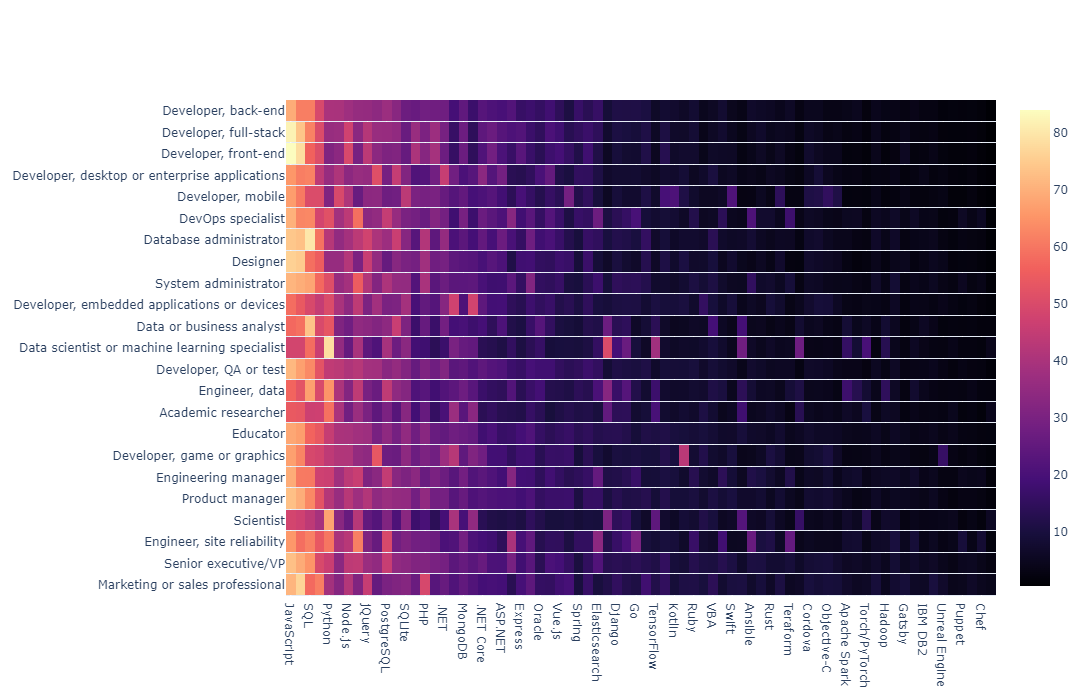

In [35]:
fig = go.Figure(data=go.Heatmap(z=skills,x=skills.columns,y=skills.index,colorscale='magma',ygap=1))
fig.update_layout(width=1000,height=700)

fig.show()

Create Jobs Dendogram

In [ ]:
# roles_short_dict = roles_names.set_index('Original name')["Short name "].to_dict()
# short_labels = [roles_short_dict[role] for role in sorted_roles]

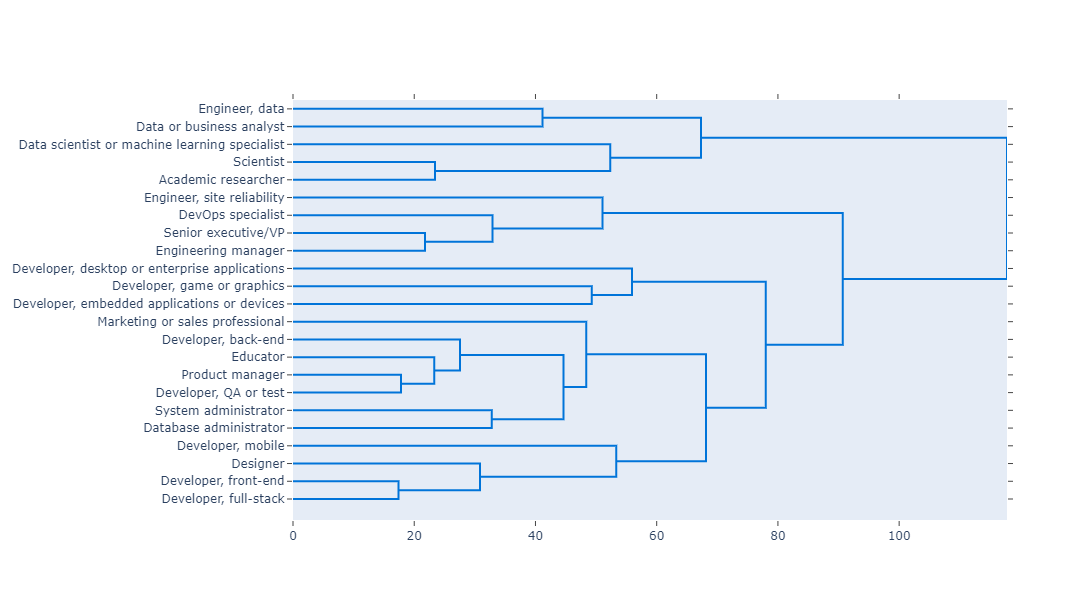

In [38]:
fig = ff.create_dendrogram(skills,labels=sorted_roles,orientation='left',color_threshold=0)
fig.update_layout(height=600,width=800,showlegend=False)
fig.show()

Normalizing features